ssp126 - tas shape: (1021, 48, 72)
ssp370 - tas shape: (1021, 48, 72)
ssp585 - tas shape: (1021, 48, 72)
ssp245 - tas shape: (1021, 48, 72)
Latitude: 48 Longitude: 72
Time steps: 1021
Ensemble members: 3


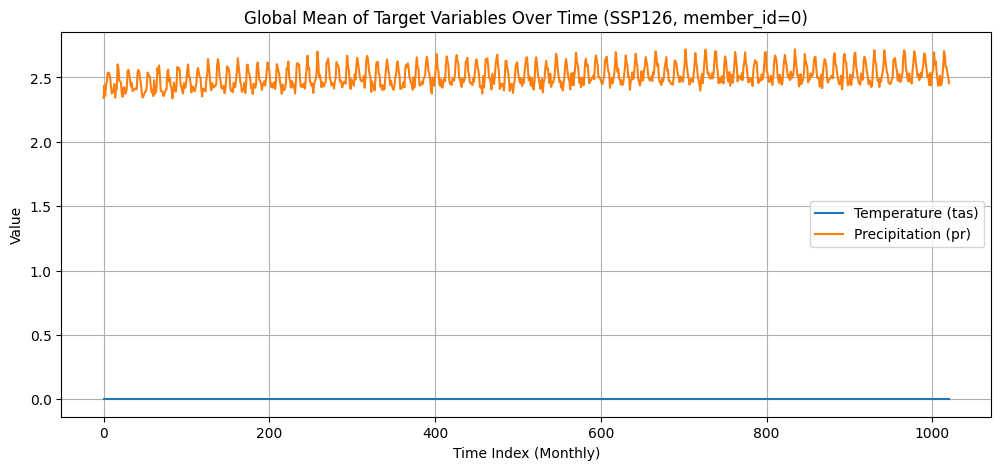

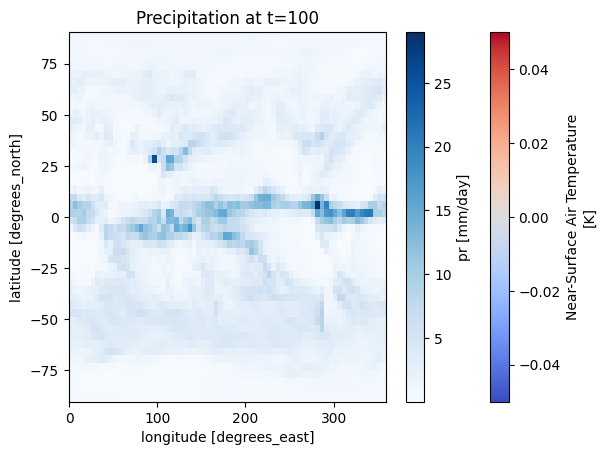

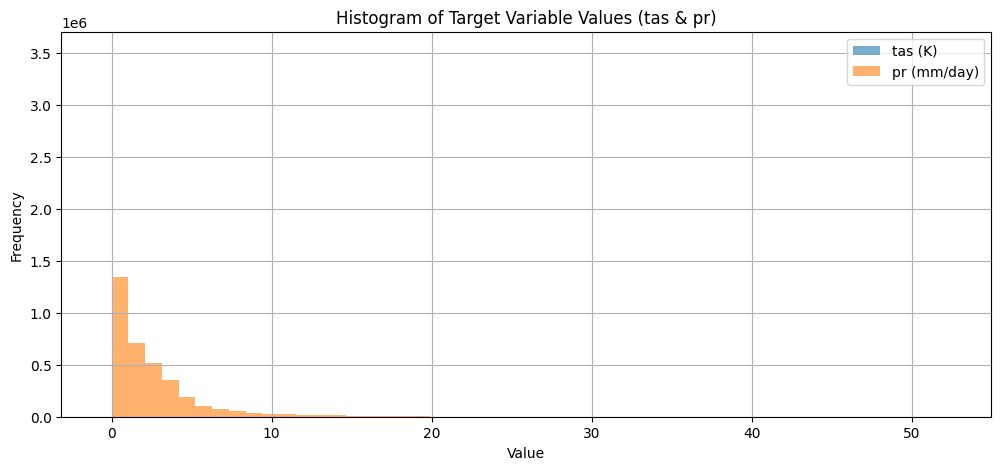

tas mean: 0.0
tas std: 0.0
pr mean: 2.5113306045532227
pr std: 2.949535369873047


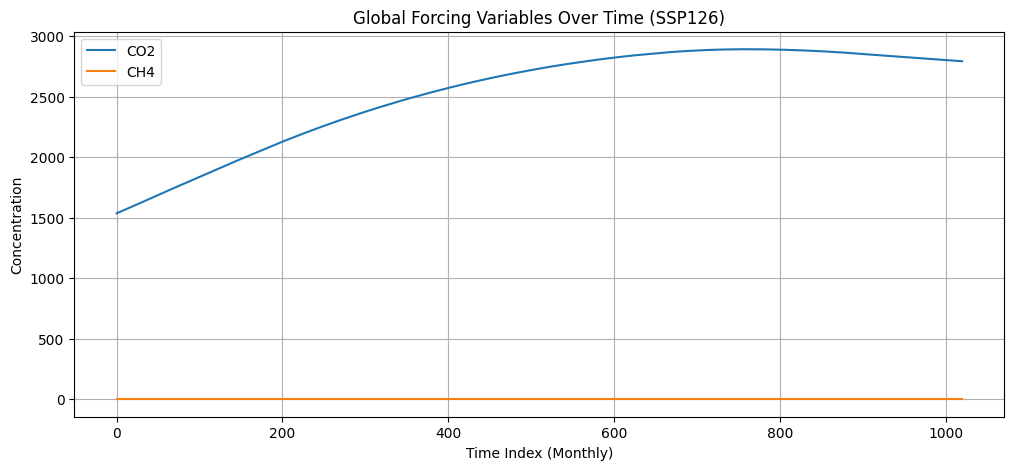

CO2 mean: 2532.318713977056
CO2 std: 401.69992064797714
CH4 mean: 0.1990533398174867
CH4 std: 0.07149415080379436


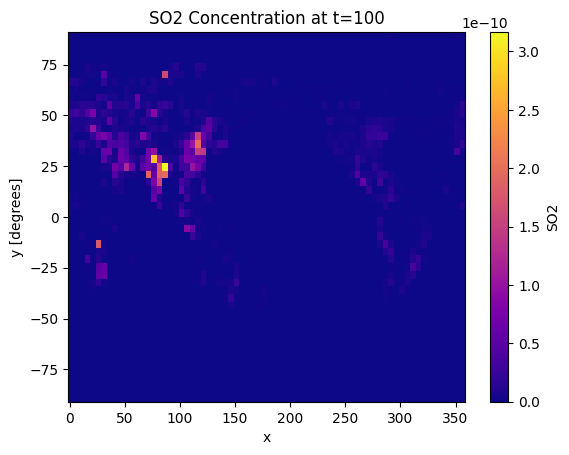

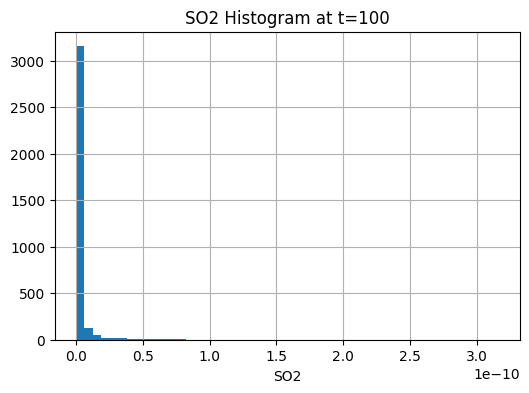

SO2 mean (t=100): 3.286404880927843e-12
SO2 std (t=100): 1.5254794142285377e-11


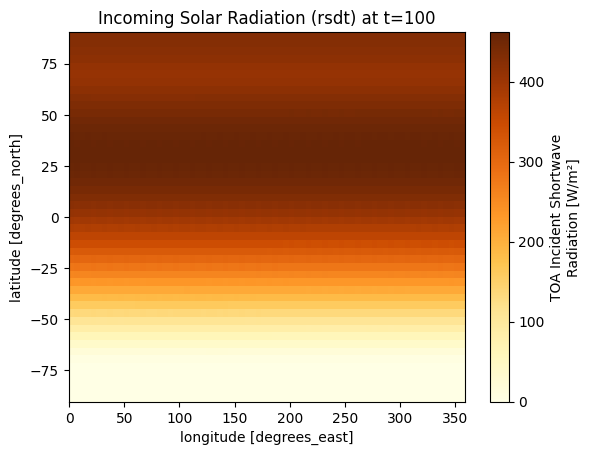

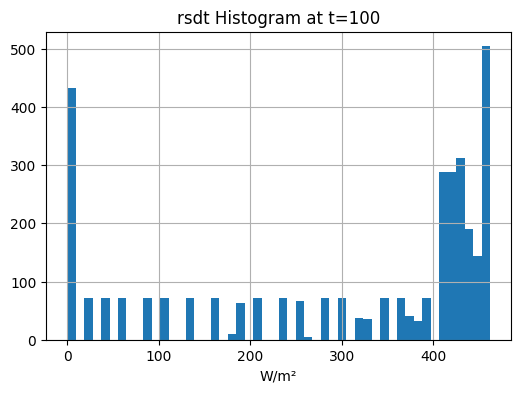

rsdt mean (t=100): 298.6604309082031
rsdt std (t=100): 168.6522979736328


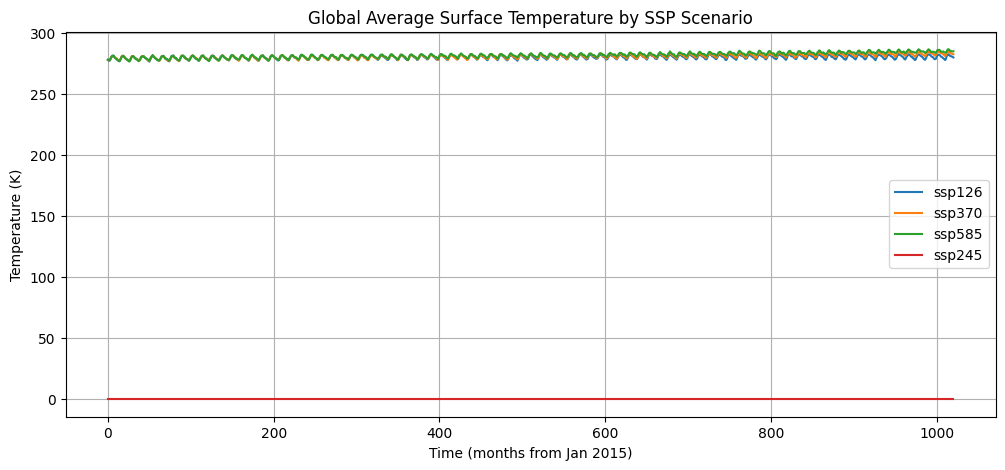

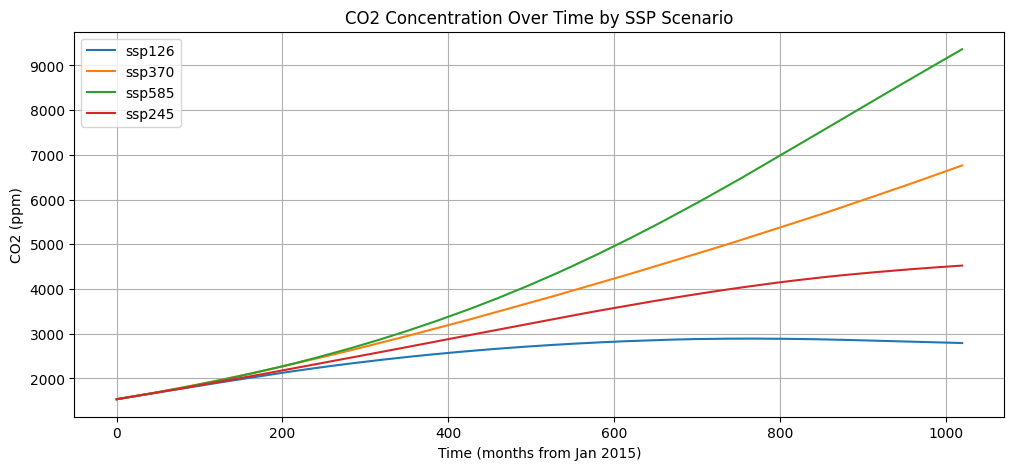

In [1]:
import xarray as xr
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt

path = "data/processed.zarr"
ds = xr.open_zarr(path, consolidated=True)

ssp = "ssp126"
member_id = 0
template = ds["rsdt"].sel(ssp=ssp).isel(time=0)

input_vars = ["CO2", "CH4", "SO2", "BC", "rsdt"]
inputs = []
for var in input_vars:
    da_var = ds[var].sel(ssp=ssp)
    if "member_id" in da_var.dims:
        da_var = da_var.sel(member_id=member_id)
    if "latitude" in da_var.dims:
        da_var = da_var.rename({"latitude": "y", "longitude": "x"})
    if set(da_var.dims) == {"time"}:
        da_var = da_var.broadcast_like(template)
    if set(da_var.dims) == {"time", "y", "x"}:
        inputs.append(da_var)

tas = ds["tas"].sel(ssp=ssp, member_id=member_id)
pr = ds["pr"].sel(ssp=ssp, member_id=member_id)
tas = tas.rename({"latitude": "y", "longitude": "x"}) if "latitude" in tas.dims else tas
pr = pr.rename({"latitude": "y", "longitude": "x"}) if "latitude" in pr.dims else pr

ds = xr.open_zarr("data/processed.zarr", consolidated=True)
for ssp in ["ssp126", "ssp370", "ssp585", "ssp245"]:
    tas = ds["tas"].sel(ssp=ssp, member_id=0)
    print(f"{ssp} - tas shape:", tas.shape)
print("Latitude:", ds.y.shape[0], "Longitude:", ds.x.shape[0])
print("Time steps:", ds.time.shape[0])
print("Ensemble members:", ds.member_id.shape[0])

tas_global_mean = tas.mean(dim=("y", "x")).compute()
pr_global_mean = pr.mean(dim=("y", "x")).compute()
plt.figure(figsize=(12, 5))
plt.plot(tas_global_mean, label="Temperature (tas)")
plt.plot(pr_global_mean, label="Precipitation (pr)")
plt.title("Global Mean of Target Variables Over Time (SSP126, member_id=0)")
plt.xlabel("Time Index (Monthly)")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

tas.isel(time=100).plot(cmap="coolwarm")
plt.title("Surface Temperature at t=100")
pr.isel(time=100).plot(cmap="Blues")
plt.title("Precipitation at t=100")

plt.figure(figsize=(12, 5))
plt.hist(tas.values.flatten(), bins=50, alpha=0.6, label="tas (K)")
plt.hist(pr.values.flatten(), bins=50, alpha=0.6, label="pr (mm/day)")
plt.title("Histogram of Target Variable Values (tas & pr)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

print("tas mean:", float(tas.mean().compute()))
print("tas std:", float(tas.std().compute()))
print("pr mean:", float(pr.mean().compute()))
print("pr std:", float(pr.std().compute()))

co2 = ds["CO2"].sel(ssp="ssp126").compute()
ch4 = ds["CH4"].sel(ssp="ssp126").compute()
plt.figure(figsize=(12, 5))
plt.plot(co2, label="CO2")
plt.plot(ch4, label="CH4")
plt.title("Global Forcing Variables Over Time (SSP126)")
plt.xlabel("Time Index (Monthly)")
plt.ylabel("Concentration")
plt.legend()
plt.grid()
plt.show()
print("CO2 mean:", float(co2.mean().compute().item()))
print("CO2 std:", float(co2.std().compute().item()))
print("CH4 mean:", float(ch4.mean().compute().item()))
print("CH4 std:", float(ch4.std().compute().item()))

so2 = ds["SO2"].sel(ssp="ssp126").isel(time=100)
so2 = so2.rename({"latitude": "y", "longitude": "x"}) if "latitude" in so2.dims else so2
so2.plot(cmap="plasma")
plt.title("SO2 Concentration at t=100")
plt.figure(figsize=(6, 4))
plt.hist(so2.values.flatten(), bins=50)
plt.title("SO2 Histogram at t=100")
plt.xlabel("SO2")
plt.grid()
plt.show()
print("SO2 mean (t=100):", float(so2.mean().compute().item()))
print("SO2 std (t=100):", float(so2.std().compute().item()))

rsdt = ds["rsdt"].sel(ssp="ssp126").isel(time=100)
rsdt.plot(cmap="YlOrBr")
plt.title("Incoming Solar Radiation (rsdt) at t=100")
plt.figure(figsize=(6, 4))
plt.hist(rsdt.values.flatten(), bins=50)
plt.title("rsdt Histogram at t=100")
plt.xlabel("W/m²")
plt.grid()
plt.show()
print("rsdt mean (t=100):", float(rsdt.mean().compute().item()))
print("rsdt std (t=100):", float(rsdt.std().compute().item()))

plt.figure(figsize=(12, 5))
for ssp in ["ssp126", "ssp370", "ssp585", "ssp245"]:
    tas = ds["tas"].sel(ssp=ssp, member_id=0)
    tas_global_mean = tas.mean(dim=("y", "x")).compute()
    plt.plot(tas_global_mean, label=ssp)
plt.title("Global Average Surface Temperature by SSP Scenario")
plt.xlabel("Time (months from Jan 2015)")
plt.ylabel("Temperature (K)")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
for ssp in ["ssp126", "ssp370", "ssp585", "ssp245"]:
    co2 = ds["CO2"].sel(ssp=ssp).compute()
    plt.plot(co2, label=ssp)
plt.title("CO2 Concentration Over Time by SSP Scenario")
plt.xlabel("Time (months from Jan 2015)")
plt.ylabel("CO2 (ppm)")
plt.legend()
plt.grid()
plt.show()
